# Exercise 7

In [2]:
from PIL import Image
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.sparse.linalg import cg


## 1 Gaussian process regression (20 points)

<div style="color: green;">
    You are only excluding values that are exactly zero, which is not a good practice for floating point numbers due to precision errors.
    Use a truncation like 1e-5 instead, e.g. `np.where(yi <= 1e-5)`.
</div>

In [3]:
# load the image
image_path = "cc_90.png"
image = Image.open(image_path)

image_array = np.array(image)

# initialize the Xi  and yi
height, width = image_array.shape

# Create the feature matrix (pixel coordinates)
Xi = np.array([(x, y) for x in range(width) for y in range(height)])
yi = image_array.ravel()
missing_indices = np.where(yi == 0)[0]
training_indices = np.where(yi != 0)[0]
# Remove the missing pixels from Xi and yi
Xi_train = np.delete(Xi, missing_indices, axis=0)
Xi_test = np.delete(Xi, training_indices, axis=0)
yi_train = np.delete(yi, missing_indices)
print("Xi_train:",Xi_train)


Xi_train: [[  0  29]
 [  0  40]
 [  0  45]
 ...
 [249 314]
 [249 317]
 [249 326]]


<div style="color: green;">
    You used h inversely (Which is not an issue, just a convention thing), and I think you confused the axes on x1? That would also explain the flipped afterimage you get in the end.
</div>

In [4]:
# Define the custom kernel function
def custom_kernel(x1, x2, gamma, h):
    r = h * np.linalg.norm(x1[:, None, :] - x2[None, :, :], axis=-1)
    return np.exp(-r**gamma)


In [5]:
# Compute the pairwise similarities between training points using the custom kernel
A = custom_kernel(Xi_train, Xi_train, 1.0, 1.0)
# Create a sparse matrix using the modified kernel matrix A
threshold = 1e-6
A[A < threshold] = 0
print(A)

[[1.00000000e+00 1.67017008e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.67017008e-05 1.00000000e+00 6.73794700e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.73794700e-03 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  4.97870684e-02 6.14421235e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.97870684e-02
  1.00000000e+00 1.23409804e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.14421235e-06
  1.23409804e-04 1.00000000e+00]]


In [6]:
def compute_similarity_vector_batch(X1, X2, gamma, h, batch_size=1000):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    b = np.zeros((n1, n2),dtype=np.float32)
    
    for i in range(0, n2, batch_size):
        batch_X2 = X2[i:i+batch_size]
        batch_kernel_matrix = custom_kernel(X1, batch_X2, gamma, h)
        
        b[:, i:i+batch_size] = batch_kernel_matrix
    
    return b

In [7]:
# Compute the similarities between training points and the test point using the custom kernel
# b = custom_kernel(Xi_train, Xi_test, 1.0, 1.0)
b = compute_similarity_vector_batch(Xi_train, Xi_test, 1.0, 1.0, batch_size=1000)
print(b)

[[2.54366569e-13 6.91440015e-13 1.87952887e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.24835413e-18 1.15482239e-17 3.13913289e-17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.86251861e-20 7.78113228e-20 2.11513107e-19 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.58256069e-10
  2.78946810e-10 1.02618795e-10]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.52299791e-08
  5.60279645e-09 2.06115369e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.23409802e-04
  4.53999310e-05 1.67017006e-05]]


<div style="color: green;">
    Where is your Gaussian regression?
</div>

In [8]:
# Compute the noise variance matrix
sigma_squared = 0.1
noise_variance = sigma_squared * np.eye(len(Xi_train))

# Add noise variance matrix to A
A += noise_variance

# Convert the matrix A to a sparse COO matrix
A_sparse = sp.coo_matrix(A)

# Get the number of diagonals in the banded matrix
num_diagonals = A_sparse.shape[1]

# Convert the matrix A to a banded matrix
banded_matrix = sp.diags(A_sparse.diagonal(), offsets=0)


# # Solve the linear system using scipy.sparse.linalg.spsolve
# z = cg.spsolve(banded_matrix, yi_train)
# # Compute the predicted response vector ŷ
# y_pred = np.zeros(len(Xi_test))

# # Compute the similarities between training points and the test points using the custom kernel
# for i, x_test in enumerate(Xi_test):
#     b = custom_kernel(Xi_train, x_test.reshape(1, 2), 1.0, 1.0)
#     y_pred[i] = np.dot(b.T, z)

# # Reshape the predicted response vector into the shape of the original image
# reconstructed_image = yi.reshape(height, width)
# reconstructed_image[missing_indices // width, missing_indices % width] = y_pred

# # Plot the original image and the reconstructed image side by side
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(image_array, cmap='gray')
# axes[0].set_title('Original Image')
# axes[1].imshow(reconstructed_image, cmap='gray')
# axes[1].set_title('Reconstructed Image')
# plt.show()


<div style="color: green;">
    The Nadaraya-Watson regression looks fine, except for the aforementioned axis flip in your kernel construction, which leads to the reconstruction being flipped and creating the strange flipped afterimage instead of filling the gaps.
</div>

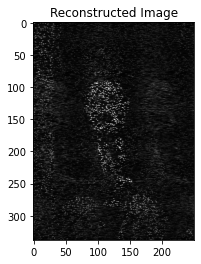

In [17]:
# Compute the norm of b
norm_b = np.linalg.norm(b, ord=1)

# Compute the predicted response vector ŷ
y_pred = np.dot(b.T, yi_train) / norm_b

# Reshape the predicted response vector into the shape of the original image
reconstructed_image = yi.reshape(height, width)
reconstructed_image[missing_indices // width, missing_indices % width] = y_pred

# Plot the original image and the reconstructed image side by side
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()


## 2 Fitting Circles

<div style="color: green;">
    Smaller markers for the scatter plot probably would have made it easier to see, but the circles can still be recognized.
    You missed a circle segment to the left because of this, at x = 0.1 and 0.2 < y < 0.8.
</div>

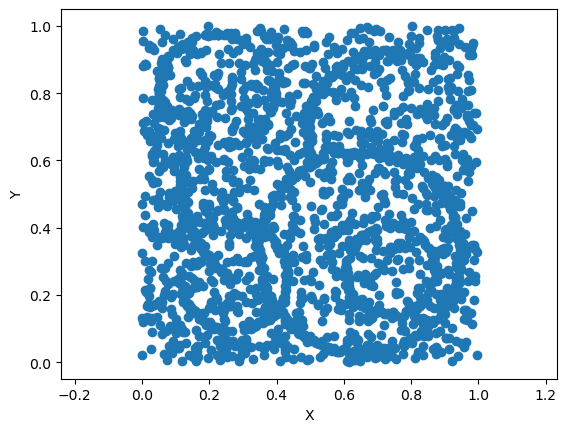

In [3]:
# Visualize the data in a scatter plot to show that the points are arranged in the shape of several circles and circle segments

data = np.load("EML_ex07_material/circles.npy")

plt.scatter(data[:, 0], data[:, 1])
plt.axis('equal')

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Q: How many circles or circle segments would you fit into the data as a human?

A: As a human, by visualizing the plot image, I found 3 circles and 2 circle segments.
    Circle: left-top corner, left-bottom corner, 3 in right-bottom corner.
    Circle-segment: left side (x: 0.1 - 0.3; y: 0.2 - 0.8); right-top corner (x: 0.5 - 0.9; y :0.6 - 0.9)

### 2.1 RANSAC (8 Points)

<div style="color: green;">
    It probably would have been easier to use the circle formula `(x - cx)**2 + (y - cy)**2 = r**2`, input all three points, and use the NumPy solver to solve for cx, cy, and r.
    RANSAC itself is mostly identical to the sample solution.
</div>

In [4]:
# Calculate the circumcircle
def calculate_circle(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    
    # Calculate the center coordinates
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    cx = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    cy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    # Calculate the radius
    r = np.sqrt((cx - x1)**2 + (cy - y1)**2)
    
    return cx, cy, r

def ransac_circles(data, T, epsilon):
    best_circle = None
    best_inliers = np.array([])
    
    for _ in range(T):
        if data.shape[0] < 3:
            break
        
        # Randomly choose three points
        sample_indices = np.random.choice(data.shape[0], 3, replace=False)
        sample_points = data[sample_indices]
        
        # Calculate the circumcircle for the sample points
        cx, cy, r = calculate_circle(sample_points)
        
        # Classify points as inliers
        distances = np.sqrt((data[:, 0] - cx)**2 + (data[:, 1] - cy)**2)
        inliers = data[distances < epsilon]
        
        # Update best circle if necessary
        if inliers.shape[0] > best_inliers.shape[0]:
            best_circle = (cx, cy, r)
            best_inliers = inliers
    
    return best_circle, best_inliers


<div style="color: green;">
    You are generating way too many circles, it is basically impossible to read anything from your plots.
    You are trying to fit everything onto circles, instead of only keeping the best x results (Or limiting the circle search to 5, which would make sense since you only identified 5 circles or circle segments).
</div>

In [5]:
def calculate_and_plot(T, epsilon):
    
    data = np.load("EML_ex07_material/circles.npy")

    circles = []
    inliers_all = []

    while True:
        best_circle, best_inliers = ransac_circles(data, T, epsilon)
        if best_circle is None:
            break
    
        circles.append(best_circle)
        inliers_all.append(best_inliers)
        data = np.delete(data, best_inliers.astype(int), axis=0)  # Convert indices to integers
    
    plt.scatter(data[:, 0], data[:, 1])

    for circle in circles:
        cx, cy, r = circle
        circle_patch = plt.Circle((cx, cy), r, fill=False)
        plt.gca().add_patch(circle_patch)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("T:" + str(T) + "/Epsilon:" + str(epsilon))
    plt.axis('equal')
    plt.show()


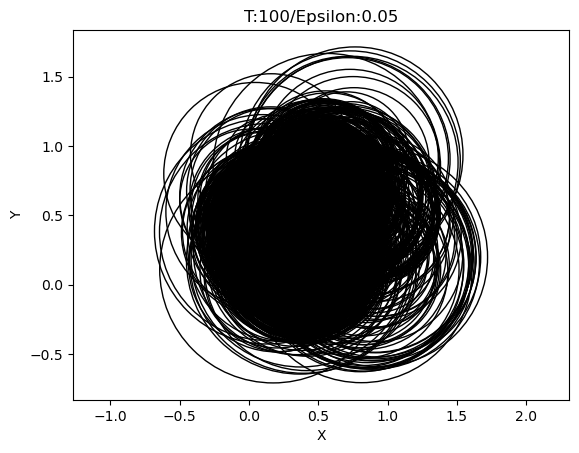

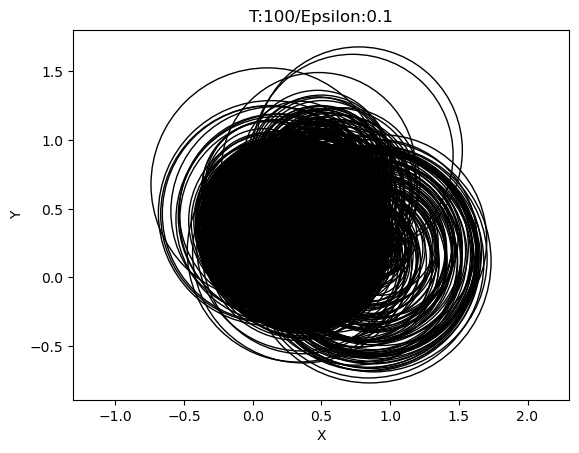

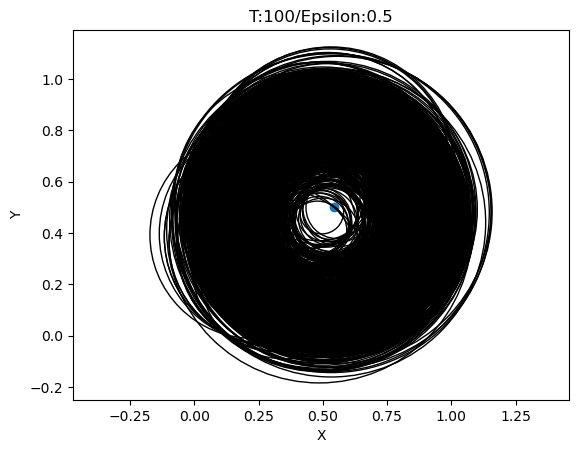

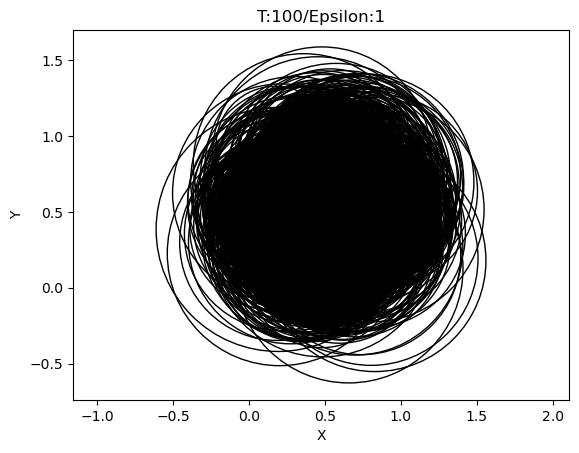

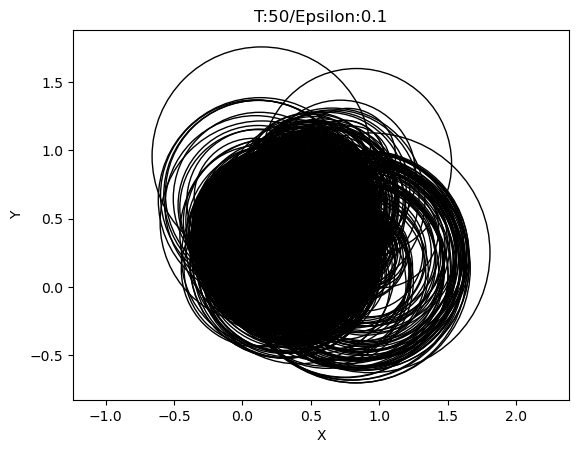

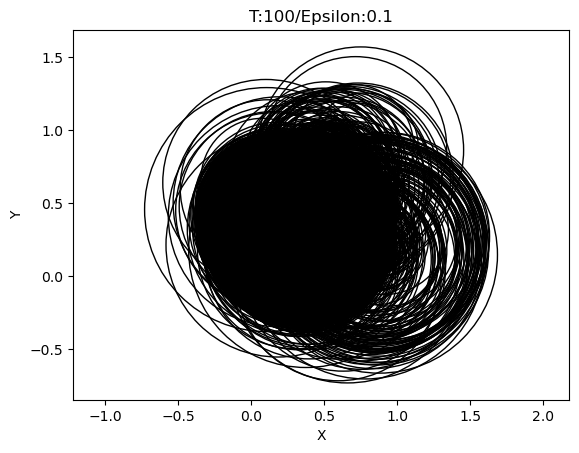

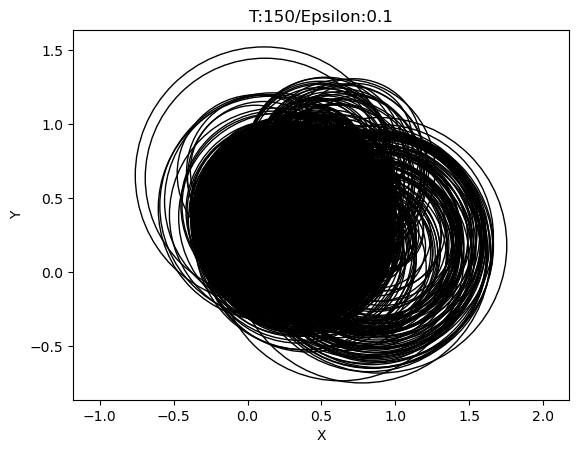

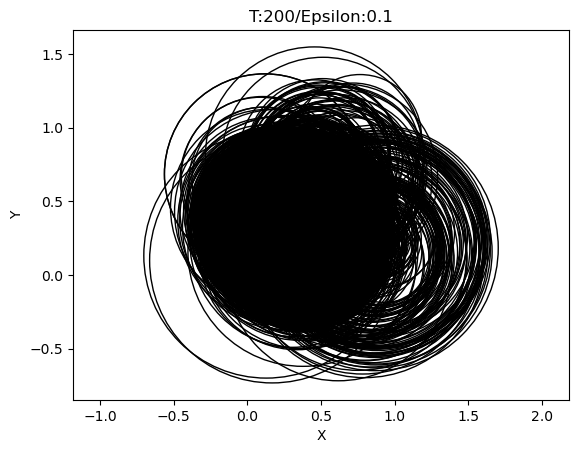

In [7]:
T = 100
epsilon = 0.1

calculate_and_plot(100, 0.05) # T = 100, epsilon = 0.05
calculate_and_plot(100, 0.1) # T = 100, epsilon = 0.1
calculate_and_plot(100, 0.5) # T = 100, epsilon = 0.5
calculate_and_plot(100, 1) # T = 100, epsilon = 1
calculate_and_plot(50, 0.1) # T = 50, epsilon = 0.1
calculate_and_plot(100, 0.1) # T = 100, epsilon = 0.1
calculate_and_plot(150, 0.1) # T = 150, epsilon = 0.1
calculate_and_plot(200, 0.1) # T = 200, epsilon = 0.1